# Set-up

In [1]:
import os
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib import colors
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cmcrameri import cm

from treeconfigparser import TreeConfigParser

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import models.reg as rg
import models.seg as sg
from Data import Data_eval
from include.loss import pixel_weighted_cross_entropy, calculate_weighted_plume
from include import generators
import model_eval

import matplotlib_functions
matplotlib_functions.setMatplotlibParam()
plt.viridis()

import ddeq_cosmo.build_ds as build_ds
from ddeq_cosmo.ddeq_eval import get_mean_loss, shift_to_proba, get_all_loss
from scipy.optimize import differential_evolution

from omegaconf import DictConfig, OmegaConf
from cfg.convert_cfg_to_yaml import save_myyaml_from_mycfg

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"
dir_plots = "/cerea_raid/users/dumontj/dev/coco2/dl/eval/paper-seg"
dir_eval_ddeq = "/libre/dumontj/coco2/ddeq/eval"

Segmentation Models: using `keras` framework.
/cerea_raid/users/dumontj/dev/coco2/dl


<Figure size 1920x1440 with 0 Axes>

## DDEQ

In [43]:
def get_b1_pred(y_test):
    b1_pred_test = 0.1*tf.ones(shape=y_test.shape)
    res = differential_evolution(get_mean_loss, args=(y_test, b1_pred_test), bounds = [[0,1], [0,1]])
    [proba_min, proba_max] = res["x"]

    shifted_b1_pred_test = shift_to_proba(b1_pred_test,proba_max,proba_min)
    return shifted_b1_pred_test

In [44]:
def get_b2_pred(y_test, ddeq_pred_bool):
    res = differential_evolution(get_mean_loss, args=(y_test, ddeq_pred_bool), bounds = [[0,1], [0,1]])
    [proba_min, proba_max] = res["x"]
    loss_mean = res["fun"]

    shifted_b2_pred_test = shift_to_proba(ddeq_pred_bool,proba_max,proba_min)
    return shifted_b2_pred_test

In [45]:
def get_weighted_y_test(plume, min_w, max_w):
    w_plume = calculate_weighted_plume(plume, min_w, max_w)
    y_test = tf.convert_to_tensor(w_plume, np.float32) 
    return y_test

In [46]:
PS = "Berlin"
ds_ber = xr.open_dataset(os.path.join(dir_eval_ddeq, 
                                  build_ds.get_abbrev_source(PS),
                                  "res_ddeq.nc"))

In [47]:
y_test_05 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=0.5)
y_test_1 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=1)
y_test_2 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=2)
y_test_4 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=4)
y_test_6 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=6)
y_test_8 = get_weighted_y_test(ds_ber.plume.values, min_w=0.01, max_w=8)

In [48]:
shifted_b1_pred_05 = get_b1_pred(y_test_05)
shifted_b1_pred_1 = get_b1_pred(y_test_1)
shifted_b1_pred_2 = get_b1_pred(y_test_2)
shifted_b1_pred_4 = get_b1_pred(y_test_4)
shifted_b1_pred_6 = get_b1_pred(y_test_6)
shifted_b1_pred_8 = get_b1_pred(y_test_8)

In [49]:
ddeq_b1_all_wbce_05 = get_all_loss(y_test_05, shifted_b1_pred_05)
ddeq_b1_all_wbce_1 = get_all_loss(y_test_1, shifted_b1_pred_1)
ddeq_b1_all_wbce_2 = get_all_loss(y_test_2, shifted_b1_pred_2)
ddeq_b1_all_wbce_4 = get_all_loss(y_test_4, shifted_b1_pred_4)
ddeq_b1_all_wbce_6 = get_all_loss(y_test_6, shifted_b1_pred_6)
ddeq_b1_all_wbce_8 = get_all_loss(y_test_8, shifted_b1_pred_8)

In [50]:
ddeq_pred_bool = tf.convert_to_tensor(np.expand_dims(ds_ber.ddeq_plumes.values, -1), np.float32) 

In [51]:
shifted_b2_pred_05 = get_b2_pred(y_test_05, ddeq_pred_bool)
shifted_b2_pred_1 = get_b2_pred(y_test_1, ddeq_pred_bool)
shifted_b2_pred_2 = get_b2_pred(y_test_2, ddeq_pred_bool)
shifted_b2_pred_4 = get_b2_pred(y_test_4, ddeq_pred_bool)
shifted_b2_pred_6 = get_b2_pred(y_test_6, ddeq_pred_bool)
shifted_b2_pred_8 = get_b2_pred(y_test_8, ddeq_pred_bool)

In [52]:
ddeq_b2_all_wbce_05 = get_all_loss(y_test_05, shifted_b2_pred_05)
ddeq_b2_all_wbce_1 = get_all_loss(y_test_1, shifted_b2_pred_1)
ddeq_b2_all_wbce_2 = get_all_loss(y_test_2, shifted_b2_pred_2)
ddeq_b2_all_wbce_4 = get_all_loss(y_test_4, shifted_b2_pred_4)
ddeq_b2_all_wbce_6 = get_all_loss(y_test_6, shifted_b2_pred_6)
ddeq_b2_all_wbce_8 = get_all_loss(y_test_8, shifted_b2_pred_8)

## CNN

In [14]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/S_pBer/2d_test_dataset.nc"

In [ ]:
name_w = "seg_ber_05"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_05 = model_eval.get_nwbce_model_on_data(model, data)

In [ ]:
name_w = "seg_ber_05"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_05 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


In [17]:
name_w = "seg_ber_1"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_1 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


In [18]:
name_w = "seg_ber_2"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_2 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


In [19]:
name_w = "seg_ber_DA_2"

model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_4 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


In [20]:
name_w = "seg_ber_6"

model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_6 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


In [21]:
name_w = "seg_ber_8"

model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_8 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


## DF and Hist

In [53]:
df_ber_CNN_05 = pd.DataFrame({'loss': all_cnn_nwbce_05,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_05) })
df_ber_05 = pd.concat([df_ber_CNN_05, pd.DataFrame({'loss': ddeq_b2_all_wbce_05 / ddeq_b1_all_wbce_05,
                       'method': ["ddeq"]*len(ddeq_b2_all_wbce_05) })], ignore_index=True)

In [54]:
df_ber_CNN_1 = pd.DataFrame({'loss': all_cnn_nwbce_1,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_1) })
df_ber_1 = pd.concat([df_ber_CNN_1, pd.DataFrame({'loss': ddeq_b2_all_wbce_1 / ddeq_b1_all_wbce_1,
                       'method': ["ddeq"]*len(ddeq_b2_all_wbce_1) })], ignore_index=True)

In [55]:
df_ber_CNN_2 = pd.DataFrame({'loss': all_cnn_nwbce_2,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_2) })
df_ber_2 = pd.concat([df_ber_CNN_2, pd.DataFrame({'loss': ddeq_b2_all_wbce_2 / ddeq_b1_all_wbce_2,
                       'method': ["ddeq"]*len(ddeq_b2_all_wbce_2) })], ignore_index=True)

In [56]:
df_ber_CNN_4 = pd.DataFrame({'loss': all_cnn_nwbce_4,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_4) })
df_ber_4 = pd.concat([df_ber_CNN_4, pd.DataFrame({'loss': ddeq_b2_all_wbce_4 / ddeq_b1_all_wbce_4,
                       'method': ["ddeq"]*len(ddeq_b2_all_wbce_4) })], ignore_index=True)

In [57]:
df_ber_CNN_6 = pd.DataFrame({'loss': all_cnn_nwbce_6,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_6) })
df_ber_6 = pd.concat([df_ber_CNN_6, pd.DataFrame({'loss': ddeq_b2_all_wbce_6 / ddeq_b1_all_wbce_6,
                       'method': ["ddeq"]*len(ddeq_b2_all_wbce_6) })], ignore_index=True)

In [58]:
df_ber_CNN_8 = pd.DataFrame({'loss': all_cnn_nwbce_8,
                      'method': ["CNN U-net"]*len(all_cnn_nwbce_8) })
df_ber_8 = pd.concat([df_ber_CNN_8, pd.DataFrame({'loss': ddeq_b2_all_wbce_8 / ddeq_b1_all_wbce_8,
                       'method': ["ddeq"]*len(ddeq_b2_all_wbce_8) })], ignore_index=True)

In [43]:
df_ber[df_ber["method"] == "ddeq"].describe()

NameError: name 'df_ber' is not defined

In [ ]:
print(df_ber[df_ber["method"]=="ddeq"].describe())
print(df_ber[df_ber["method"]=="CNN U-net"].describe())

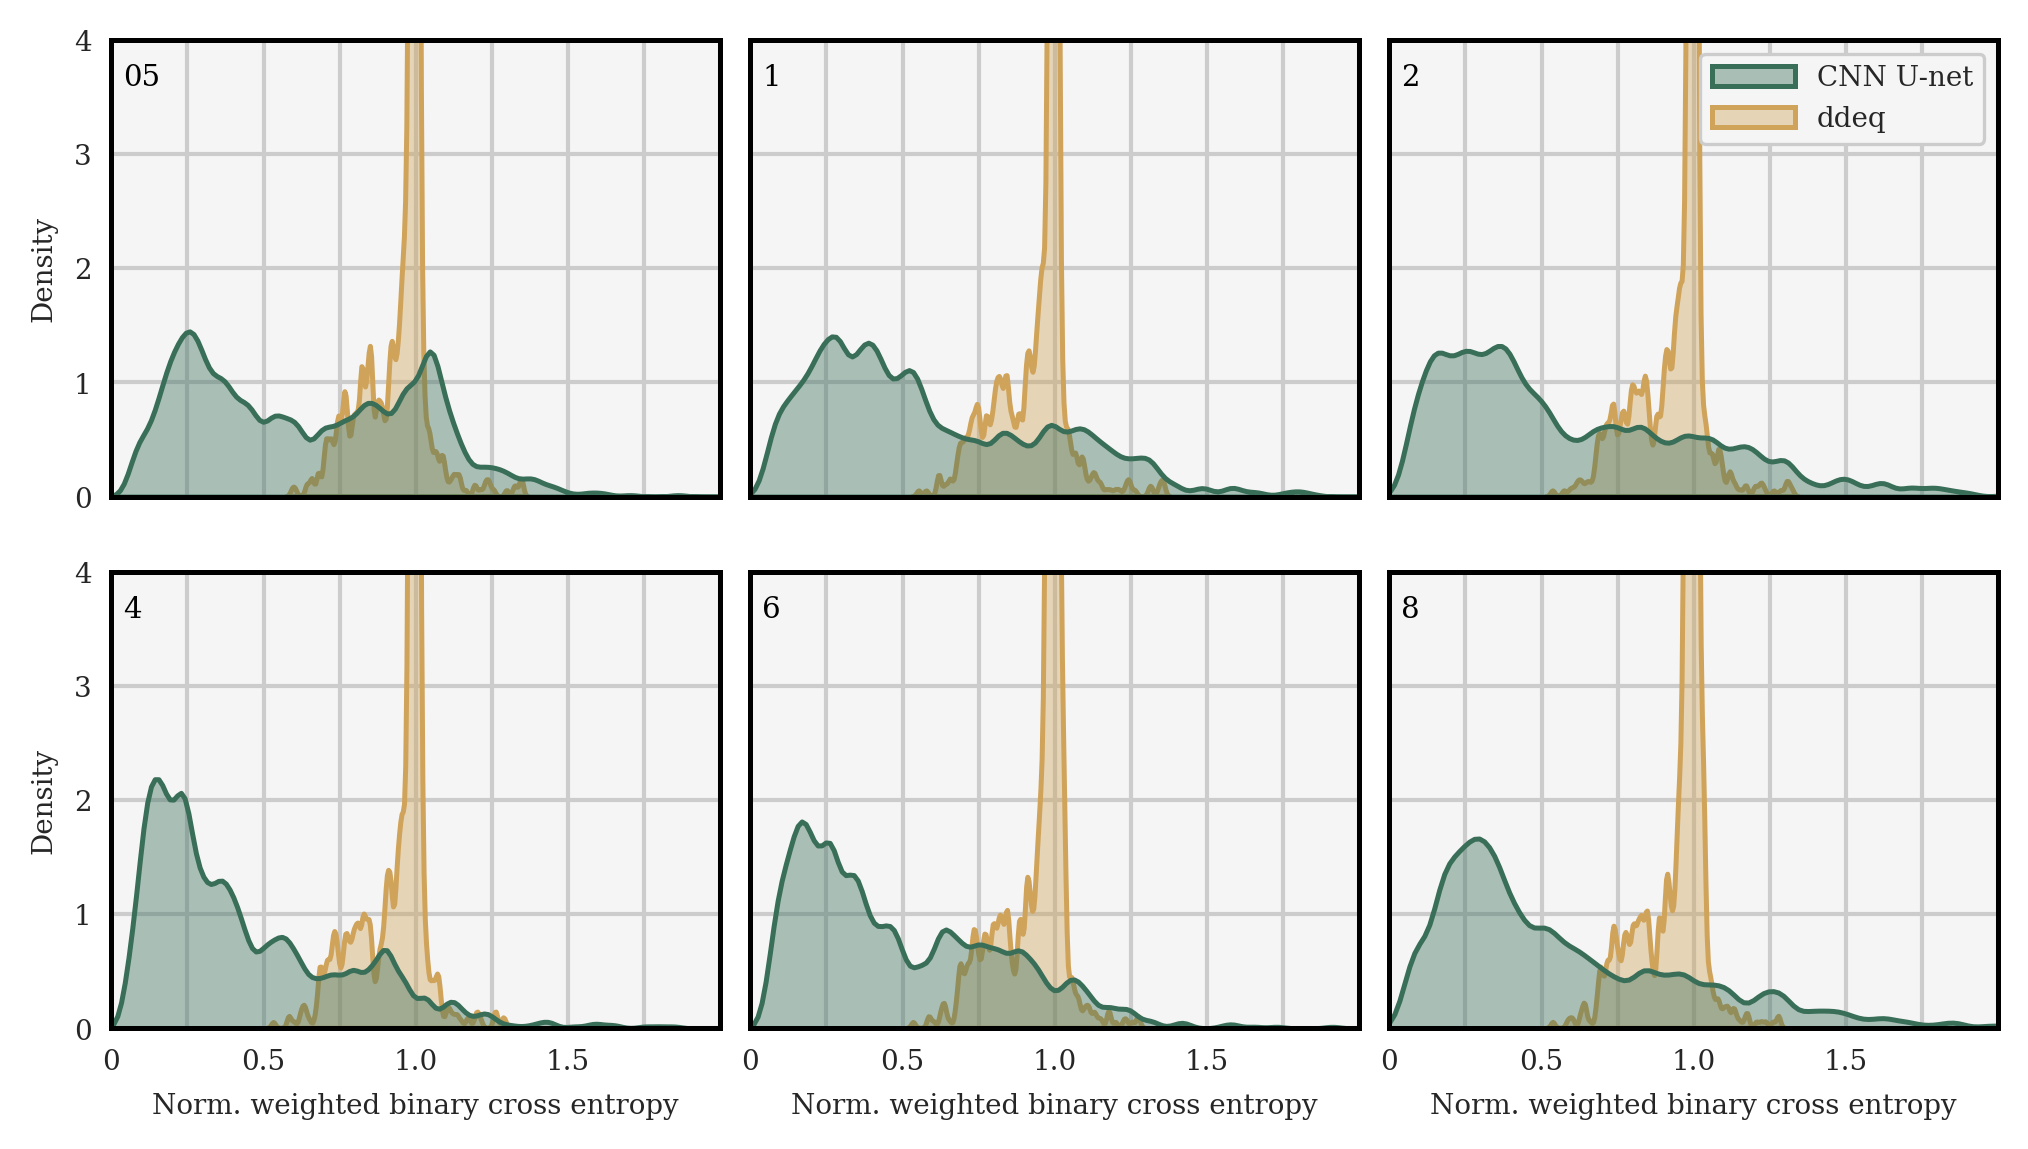

In [48]:
matplotlib_functions.setMatplotlibParam()
axs = matplotlib_functions.set_figure_axs(2, 3, wratio=0.35, hratio=0.75, 
                                          pad_w_ext_left=0.30, pad_w_ext_right=0.30, 
                                          pad_w_int=0.1, pad_h_ext=0.31, pad_h_int=0.25)

dfs = [df_ber_05, df_ber_1, df_ber_2, df_ber_4, df_ber_6, df_ber_8]
titles = ["05", "1", "2", "4", "6", "8"]

for i_ax in range(6):
    sns.kdeplot(
        data=dfs[i_ax],
        x="loss",
        hue="method",
        common_norm=False,
        fill=True,
        lw=1.2,
        alpha=0.4,
        levels=1,
        bw_adjust = 0.3, 
        ax = axs[i_ax],
        palette="cmc.batlowW", # batlowW, batlowW_r  berlin bukavu  bukavu_r vik vikO vikO_r vik_r
    )
    axs[i_ax].grid(linewidth=1., alpha=1)
    axs[i_ax].set_xlim(0,2)
    axs[i_ax].set_ylim(0,4)
    axs[i_ax].legend_.set_title(None)

for ax in axs[:3]:
    ax.set_xticklabels([])
    ax.set_xlabel("")
for ax in [axs[1], axs[2], axs[4], axs[5]]:
    ax.set_yticklabels([])
    ax.set_ylabel("")
for ax in [axs[0], axs[1], axs[3], axs[4], axs[5]]:
    ax.get_legend().remove()
for ax in axs:
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])
axs[3].set_xticklabels([0, "", 0.5, "", 1.0, "", 1.5, "", ""])
axs[4].set_xticklabels([0, "", 0.5, "", 1.0, "", 1.5, "", ""])
axs[5].set_xticklabels([0, "", 0.5, "", 1.0, "", 1.5, "", ""])
for ax in axs:
    ax.set_yticks([0, 1, 2, 3, 4])
axs[3].set_xlabel("Norm. weighted binary cross entropy")
axs[4].set_xlabel("Norm. weighted binary cross entropy")
axs[5].set_xlabel("Norm. weighted binary cross entropy")

for i, title in enumerate(titles):
    axs[i].annotate(
        title, fontsize=7, xycoords="axes fraction",
        xy=(0.02, 0.9), color="black", fontname="Serif")    

In [24]:
name_w = "seg_ber_05"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_05 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


In [40]:
model_eval.plot_segmentation_examples(
    data,
    all_cnn_nwbce_05,
    model,
)

TypeError: plot_segmentation_examples() missing 1 required positional argument: 'model'

In [37]:
name_w = "seg_ber_8"
model = model_eval.get_segmentation_model(os.path.join(dir_res, name_w))
data = model_eval.get_data_for_segmentation(os.path.join(dir_res, name_w), path_eval_nc)

all_cnn_nwbce_8 = model_eval.get_nwbce_model_on_data(model, data)

data.x.eval.shape (1152, 160, 160, 1)


nwbce: 0.35069647
idx 105
origin: smart_pBer_nBBer
time: 2015-02-04T09:00:00.000000000
emiss: [31.82424 34.47468 34.73873 32.68085 24.90133 14.42696]
nwbce: 0.17849594
idx 896
origin: smart_pBer_nBBer
time: 2015-10-05T08:00:00.000000000
emiss: [20.79829 21.51588 21.72411 20.49116 15.27605  9.65116]
nwbce: 0.84968644
idx 1137
origin: smart_pBer_nBBer
time: 2015-12-20T09:00:00.000000000
emiss: [22.52553 24.4211  24.83623 23.42077 17.59905 10.1181 ]


<Figure size 1920x1440 with 0 Axes>

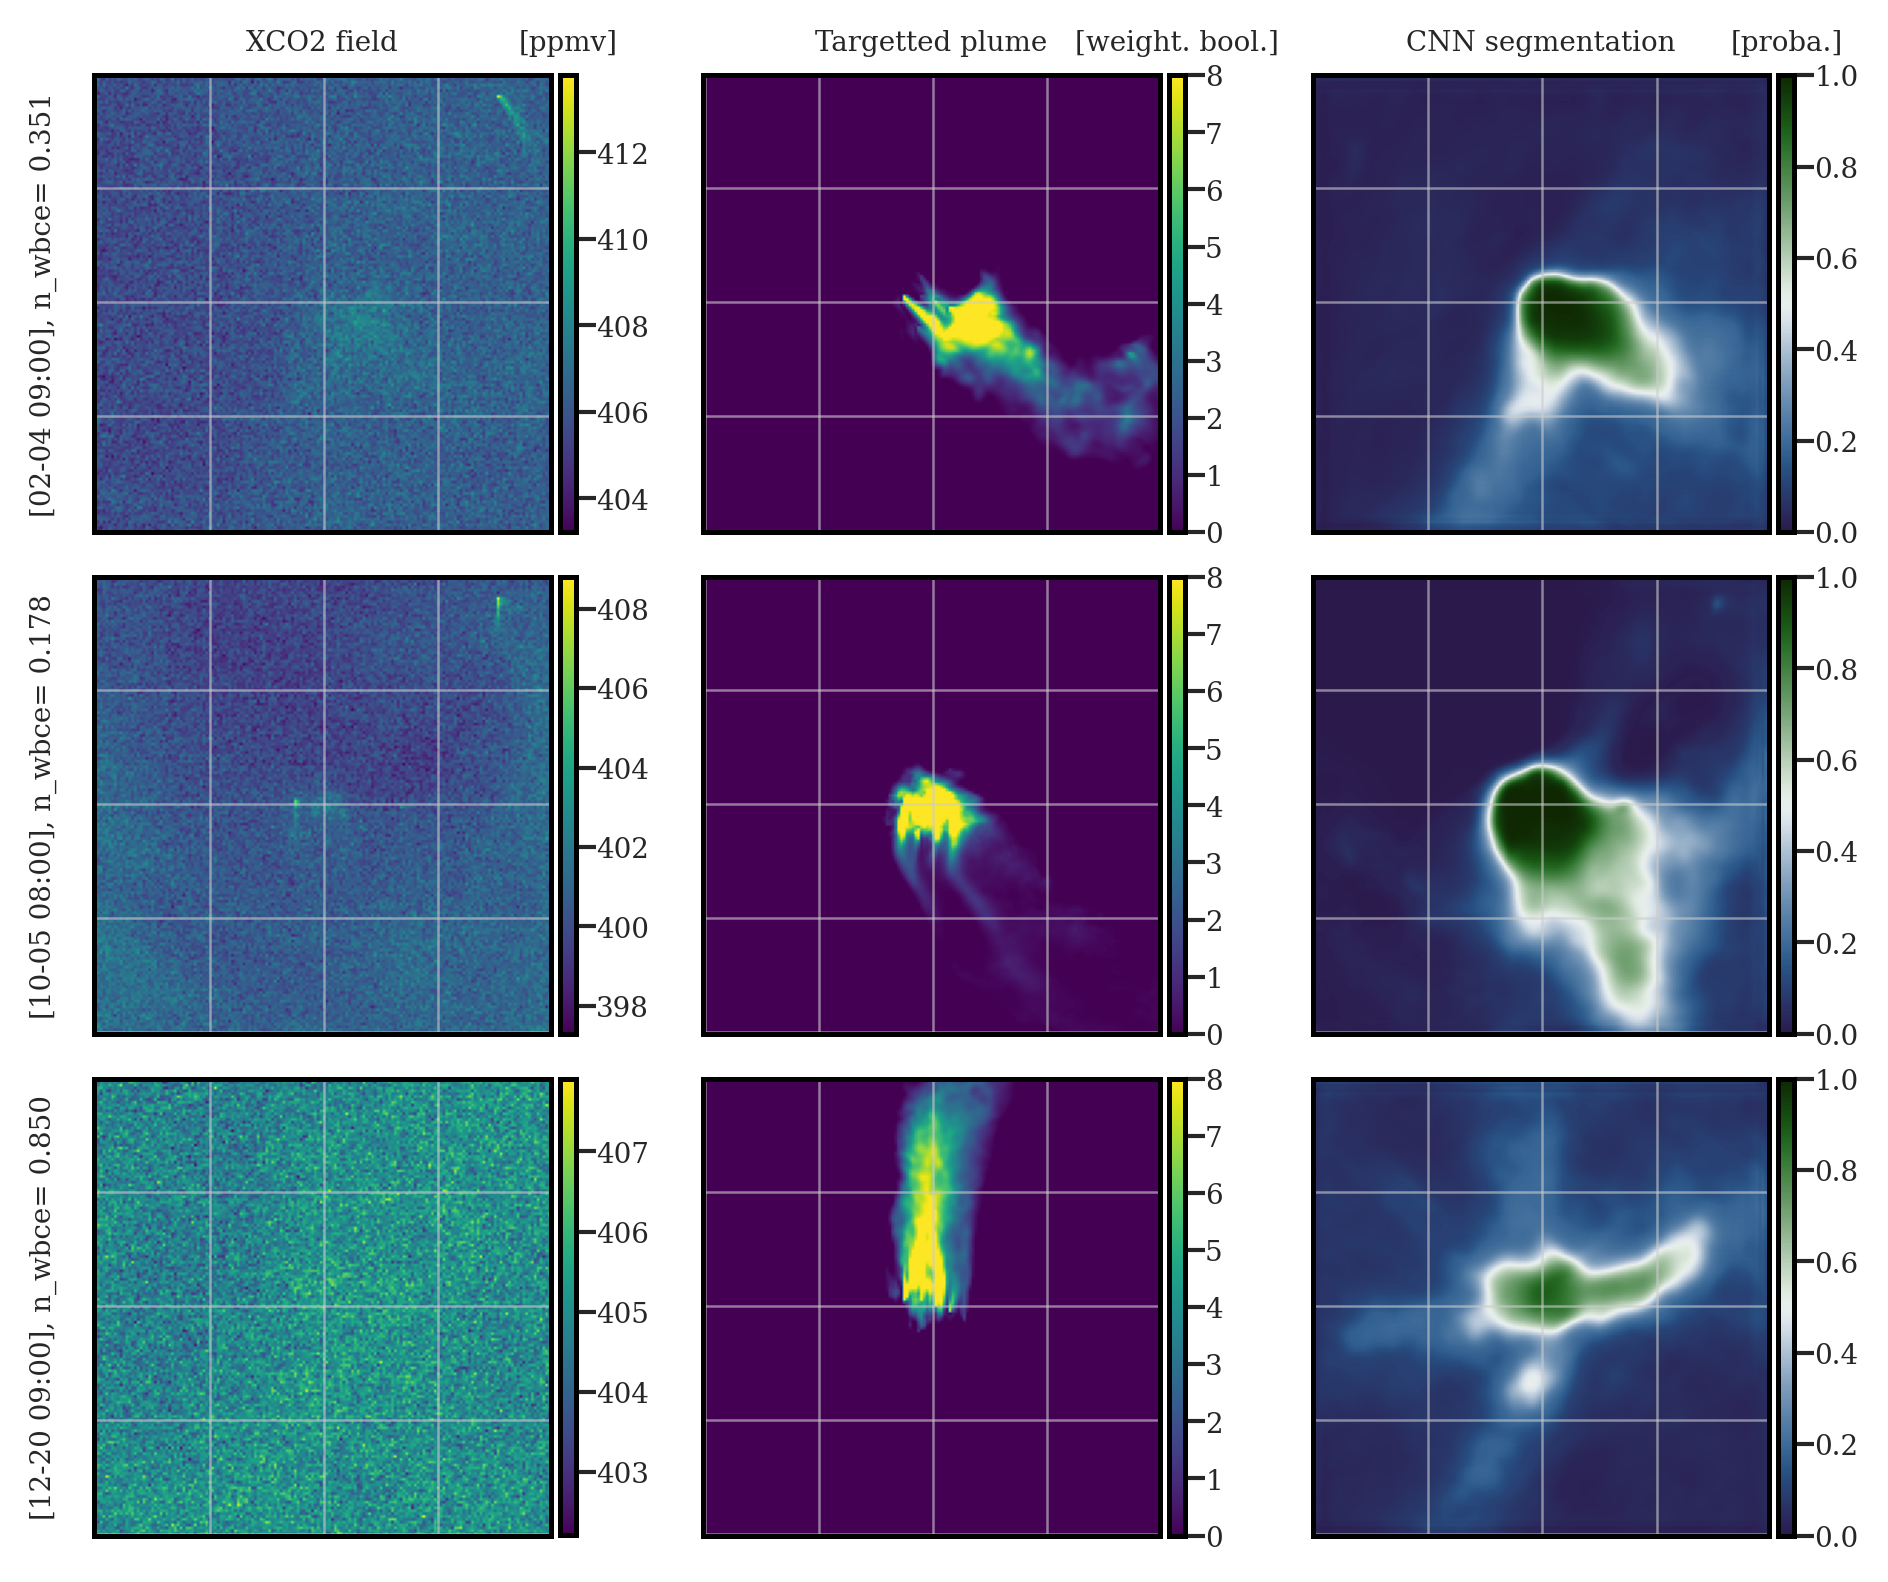

In [39]:
model_eval.plot_segmentation_examples(
    data,
    all_cnn_nwbce_8,
    data.x.scaler,
    model,
)